In [130]:
%matplotlib widget
from pyshtools import legendre
from scipy.integrate import simpson as simps
from scipy.optimize import curve_fit
from tqdm import tqdm
PAPDIR = "/scratch/seismo/kashyap/cloud/Yandex.Disk/papers-posters-docs/2025-seismo-xl"

### Filtered cross-correlation method?
- Regulo, Garcia & Ballot (2016) A&A 589, A103 demonstrated a cross-correlation method to determine average frequency changes for detecting activity cycles in stars.
- This was done as peak-bagging and determining change in frequencies when $\delta\nu\sim 0.1\mu$Hz is hard when SNR is low and this method improves the SNR
- All the $\ell$ information is lost
- Can we do slightly better? Get $\bar{\delta\nu}_\ell$ i.e. the averaged frequency changes for each spherical harmonic degree -- this would enable us to do latitudinal inversions on stars.

## How to create filters?
- We rely on the mean power spectrum from a long time series.
- Peak bagging can be performed on averaged power spectrum and mode amplitudes and frequencies can be fit
- The rotation rate and the inclination angles can be inferred as well
- Since the averaged power spectrum can be written as $P^\mathrm{model}(\omega) = P_\mathrm{background}(\omega) + \sum_{n\ell m} A_{n\ell m} L(\omega, \omega_{n\ell m}, \Gamma_{n\ell})$, where $L(\omega, \omega_{n\ell m}, \Gamma_{n\ell})$ is symmetric Lorentzian profile.
- After fitting for $\omega_{n\ell m}, A_{n\ell m}, \Gamma_{n\ell}$, filtered powerspectrum for each $\ell$ can be defined as following
$$ \mathcal{P}_\ell(\omega) = P_\mathrm{background}(\omega) + \sum_{n m} A_{n\ell m} L(\omega, \omega_{n\ell m}, \Gamma_{n\ell})$$
- The cross correlation technique is now applied to $P^\mathrm{obs}(\omega)$ and each of the filters $\mathcal{P}_\ell(\omega)$ to determine $\bar{\delta\nu}_\ell$

In [2]:
# Function to compute the visibility matrix
def get_elm(ell, emm):                                                 
    """Gets the visibility matrix for the given inclination angle.           
                                                                             
    Inputs                                                                   
    ------                                                                   
    ell : int                                                                
        Spherical harmonic degree of mode                                    
    emm : int                                                                
        abs(emm) <= ell                                                      
        azimuthal order of the mode                                          
                                                                             
    Returns                                                                  
    -------                                                                  
    elm : float                                                              
        visibility matrix, as defined by Eqn.(11) of Gizon and Solanki (2003)
    """
    Plmfunc = legendre.PLegendreA
    _Plm = Plmfunc(ell, np.cos(85*np.pi/180))
    _idx = legendre.PlmIndex(ell, abs(emm))
    pval = _Plm[_idx]
    lpm = ell + abs(emm)
    lmm = ell - abs(emm)
    lpmf = np.math.factorial(lpm)
    lmmf = np.math.factorial(lmm)
    pval = pval * np.sqrt(lmmf/lpmf)
    elm = pval**2                                                            
    return elm


def solve_inv_prob(Am, vec, regval=0.1):
    """Solves the regularized inverse problem

    Parameters
    ----------
    :Am: Forward operator
    :type: np.ndarray(ndim=2, dtype=float)

    :vec: RHS vector
    :type: np.ndarray(ndim=1, dtype=float)

    :regval: regularization value
    :type: float

    Returns
    -------
    Regularized inversion (A.T @ A)^{-1} @ (A.T @ vec)
    """
    Ata = Am.T @ Am + regval*np.identity(Am.shape[-1])
    Ainv = np.linalg.pinv(Ata, rcond=1e-6)
    return Ainv @ (Am.T @ vec)


def noisify(iparr):
    """
    Noisify the input array with a chi2-2dof distribution

    Parameters
    ----------
    :iparr: Input spectra
    :type: np.ndarray(ndim=1, dtype=float)

    Returns
    -------
    noisy_arr
    :noisy_arr: noisy counterpart of input spectra
    :type: np.ndarray(ndim=1, dtype=float)
    """
    noise = np.random.randn(*(iparr.shape))**2
    noisy_arr = iparr*noise
    return noisy_arr

def gaussian(x, *p):
    """Creates a gaussian with the defined parameters. Useful for 
    passing the function to scipy.optimize.curve_fit

    Parameters
    ----------
    :x: domain on which gaussian is defined
    :type: np.ndarray(ndim=1, dtype=float)

    :p: parameters corresponding to the gaussian
    :type: list(len=4)
        p[0] = Amplitude of gaussian
        p[1] = centroid location
        p[2] = sigma
        p[3] = dc shift

    Returns
    -------
    gaussian profile on x
    """
    A, mu, sigma, k = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2)) + k


def compute_cc(arr1, arr2, maxlag=20):
    """Computes the cross-correlation for lags in the range (-maxlag, maxlag+1)

    Parameters
    ----------
    :arr1: the raw power spectrum
    :type: np.ndarray(ndim=1, dtype=float)

    :arr2: the filter power spectrum model
    :type: np.ndarray(ndim=1, dtype=float)

    :maxlag: the maximum lag index
    :type: int
    :default: 20

    Returns
    -------
    lags, cc

    :lags: array containing list of lags
    :type: np.ndarray(ndim=1, dtype=int)
    :note: lags = np.arange(-maxlag, maxlag+1)

    :cc: cross-correlation array
    :type: np.ndarray(ndim=1, dtype=float)
    """
    maxlag = abs(int(maxlag))
    assert maxlag > 0, "maxlag should be at least 1"
    if maxlag%2>0: maxlag += 1
    cc = np.zeros(2*maxlag+1)
    lags = np.arange(-maxlag, maxlag+1)
    for idx in range(len(cc)):
        cc[idx] = np.sum(arr1*np.roll(arr2, idx-maxlag))
    return lags, cc

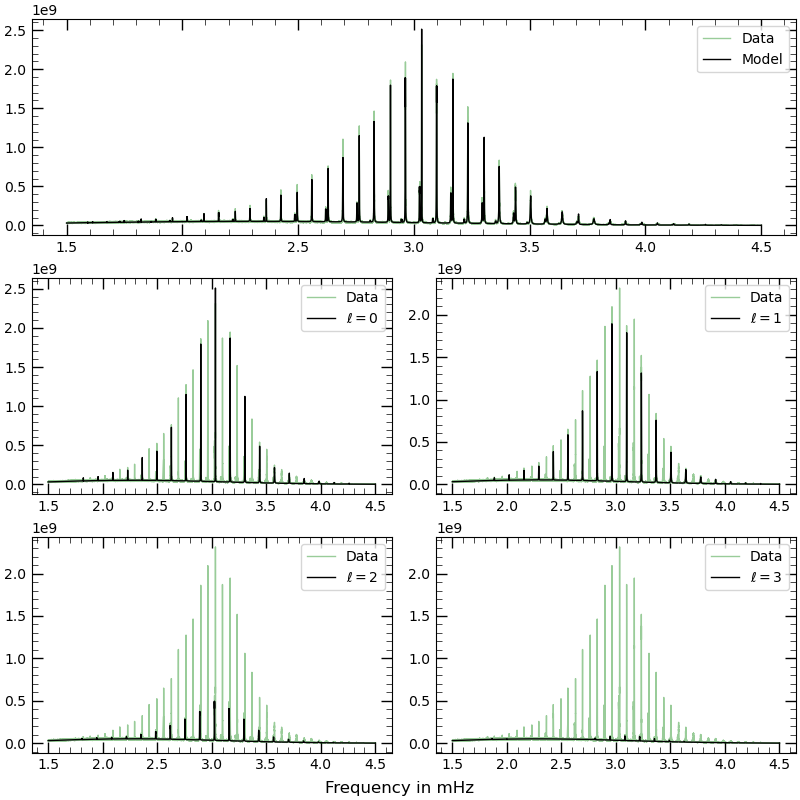

In [127]:
# Loading the power spectrum fitted parameters to construct the filtered power spectra
channel = 'red'
ncarr = 3
skipmax = 60
incl = 86
pschunks = np.load(f'/scratch/seismo/kashyap/processed/sun-intg/data/valeriy-{channel}-Ncarr{ncarr}-skip{skipmax}/pschunks-raw.npy')
gfilter = np.load(f'/scratch/seismo/kashyap/processed/sun-intg/ps-fits/valeriy-{channel}-Ncarr{ncarr}-skip{skipmax}-ell3-i{incl}/gfilter.npy')
ell = np.load(f'/scratch/seismo/kashyap/processed/sun-intg/ps-fits/valeriy-{channel}-Ncarr{ncarr}-skip{skipmax}-ell3-i{incl}/fitted-ell-list.npy')
enn = np.load(f'/scratch/seismo/kashyap/processed/sun-intg/ps-fits/valeriy-{channel}-Ncarr{ncarr}-skip{skipmax}-ell3-i{incl}/fitted-enn-list.npy')
nus = np.load(f'/scratch/seismo/kashyap/processed/sun-intg/ps-fits/valeriy-{channel}-Ncarr{ncarr}-skip{skipmax}-ell3-i{incl}/fitted-nu-list-mod.npy')
fwhm = np.load(f'/scratch/seismo/kashyap/processed/sun-intg/ps-fits/valeriy-{channel}-Ncarr{ncarr}-skip{skipmax}-ell3-i{incl}/fitted-gamma-list-mod.npy')
pobs = np.load(f'/scratch/seismo/kashyap/processed/sun-intg/data/valeriy-{channel}-Ncarr{ncarr}-skip{skipmax}/psref.npy')
amps = np.load(f'/scratch/seismo/kashyap/processed/sun-intg/ps-fits/valeriy-{channel}-Ncarr{ncarr}-skip{skipmax}-ell3-i{incl}/fitted-mode-amplitudes.npy')
amps_llk = np.load(f'/scratch/seismo/kashyap/processed/sun-intg/ps-fits/valeriy-{channel}-Ncarr{ncarr}-skip{skipmax}-ell3-i{incl}/fitted-mode-amplitudes-mod.npy')
bgamps = np.load(f'/scratch/seismo/kashyap/processed/sun-intg/ps-fits/valeriy-{channel}-Ncarr{ncarr}-skip{skipmax}-ell3-i{incl}/fitted-mode-amplitudes-mod.npy')[-2:]
#kth = np.load('/scratch/seismo/kashyap/processed/sun-intg/ps-fits/valeriy-{channel}-Ncarr{ncarr}-skip{skipmax}-ell3-i{incl}/numean-kernels.npy')
years = np.load(f'/scratch/seismo/kashyap/processed/sun-intg/data/valeriy-{channel}-Ncarr{ncarr}-skip{skipmax}/years.npy')
bsp = np.load(f'/scratch/seismo/kashyap/processed/sun-intg/bsp-basis/bsp_knotnum_15.npy')
amps_llk[-2:] = bgamps
pslbg1 = np.load(f'/scratch/seismo/kashyap/processed/sun-intg/ps-fits/valeriy-{channel}-Ncarr{ncarr}-skip{skipmax}-ell3-i{incl}/fitted-ps-list.npy')
pslbg2 = np.load(f'/scratch/seismo/kashyap/processed/sun-intg/ps-fits/valeriy-{channel}-Ncarr{ncarr}-skip{skipmax}-ell3-i{incl}/fitted-ps-list-mod.npy')
freq_mhz = np.load(f'/scratch/seismo/kashyap/processed/sun-intg/data/valeriy-{channel}-Ncarr{ncarr}-skip{skipmax}/freq.npy')*1e3
YRS = np.load(f'/scratch/seismo/kashyap/processed/sun-intg/data/valeriy-{channel}-Ncarr{ncarr}-skip{skipmax}/years.npy')
amps_llk = amps*1.0


mask_peaks = np.zeros_like(freq_mhz, dtype=bool)
for idx, nu in enumerate(nus):
    lw = fwhm[idx]
    minidx = np.argmin(abs(freq_mhz - nu*1e3 + 4*lw*1e3))
    maxidx = np.argmin(abs(freq_mhz - nu*1e3 - 4*lw*1e3))
    mask_peaks[minidx:maxidx] = True

ps1 = (amps @ pslbg1)*gfilter
ps2 = (amps @ pslbg2)*gfilter
ps3 = (amps_llk @ pslbg2)*gfilter

mask0 = (ell==0)*(nus>1.8e-3)
mask1 = (ell==1)*(nus>1.8e-3)
mask2 = (ell==2)*(nus>1.8e-3)
mask3 = (ell==3)*(nus>1.8e-3)
bgfit = (amps_llk[-2:] @ pslbg2[-2:])*gfilter
psfit0 = (amps_llk[:-2][mask0] @ pslbg2[:-2][mask0, :])*gfilter + bgfit
psfit1 = (amps_llk[:-2][mask1] @ pslbg2[:-2][mask1, :])*gfilter + bgfit
psfit2 = (amps_llk[:-2][mask2] @ pslbg2[:-2][mask2, :])*gfilter + bgfit
psfit3 = (amps_llk[:-2][mask3] @ pslbg2[:-2][mask3, :])*gfilter + bgfit

psfit01 = ((psfit0 - bgfit) + (psfit1 - bgfit) + bgfit)
psfit02 = ((psfit0 - bgfit) + (psfit2 - bgfit) + bgfit)
psfit03 = ((psfit0 - bgfit) + (psfit3 - bgfit) + bgfit)
psfit12 = ((psfit1 - bgfit) + (psfit2 - bgfit) + bgfit)
psfit13 = ((psfit1 - bgfit) + (psfit3 - bgfit) + bgfit)
psfit23 = ((psfit2 - bgfit) + (psfit3 - bgfit) + bgfit)
psfit012 = ((psfit0 - bgfit) + (psfit1 - bgfit) + (psfit2 - bgfit) + bgfit)
psfit013 = ((psfit0 - bgfit) + (psfit1 - bgfit) + (psfit3 - bgfit) + bgfit)
psfit023 = ((psfit0 - bgfit) + (psfit2 - bgfit) + (psfit3 - bgfit) + bgfit)
psfit123 = ((psfit1 - bgfit) + (psfit2 - bgfit) + (psfit3 - bgfit) + bgfit)
psfit0123 = ((psfit0 - bgfit) + (psfit1 - bgfit) + (psfit2 - bgfit) + (psfit3 - bgfit) + bgfit)

fig = plt.figure(figsize=(8, 8), layout="constrained")
spec = fig.add_gridspec(3, 2)
mask = (freq_mhz>1.5) * (freq_mhz<4.5)
ax0 = fig.add_subplot(spec[0, :])
ax0.plot(freq_mhz[mask], pobs[mask], color='green', lw=1, alpha=0.4, label='Data')
ax0.plot(freq_mhz[mask], ps3[mask], color='k', lw=1, label='Model')
ax0.legend()

ax = fig.add_subplot(spec[1, 0])
ax.plot(freq_mhz[mask], pobs[mask], color='green', lw=1, alpha=0.4, label='Data')
ax.plot(freq_mhz[mask], psfit0[mask], 'k', lw=1, label='$\\ell=0$')
ax.legend()

ax = fig.add_subplot(spec[1, 1])
ax.plot(freq_mhz[mask], pobs[mask], color='green', lw=1, alpha=0.4, label='Data')
ax.plot(freq_mhz[mask], psfit1[mask], 'k', lw=1, label='$\\ell=1$')
ax.legend()

ax = fig.add_subplot(spec[2, 0])
ax.plot(freq_mhz[mask], pobs[mask], color='green', lw=1, alpha=0.4, label='Data')
ax.plot(freq_mhz[mask], psfit2[mask], 'k', lw=1, label='$\\ell=2$')
ax.legend()

ax = fig.add_subplot(spec[2, 1])
ax.plot(freq_mhz[mask], pobs[mask], color='green', lw=1, alpha=0.4, label='Data')
ax.plot(freq_mhz[mask], psfit3[mask], 'k', lw=1, label='$\\ell=3$')
ax.legend()

fig.supxlabel('Frequency in mHz')

plt.show()

In [126]:
nus

array([0.00182224, 0.00195756, 0.00209356, 0.00222886, 0.0023629 ,
       0.0024963 , 0.00262974, 0.00276426, 0.0028991 , 0.00303382,
       0.00316872, 0.00330371, 0.00343919, 0.00357515, 0.00371135,
       0.00384803, 0.00398483, 0.00412234, 0.00425987, 0.00161274,
       0.00174934, 0.0018852 , 0.00202092, 0.0021569 , 0.00229212,
       0.00242567, 0.00255928, 0.00269349, 0.00282826, 0.00296342,
       0.00309832, 0.00323331, 0.00336871, 0.00350449, 0.00364082,
       0.00377761, 0.00391437, 0.0040519 , 0.00418856, 0.00432784,
       0.00153607, 0.00167438, 0.00181036, 0.00194581, 0.00208216,
       0.00221779, 0.0023524 , 0.00248598, 0.00261979, 0.0027546 ,
       0.00288968, 0.00302485, 0.00316001, 0.00329521, 0.00343091,
       0.00356694, 0.00370442, 0.00384202, 0.00397869, 0.00411525,
       0.00425214, 0.00439285, 0.00159159, 0.00172916, 0.00186558,
       0.00200056, 0.0021364 , 0.00227194, 0.00240574, 0.00253972,
       0.00267614, 0.0028114 , 0.00294698, 0.00308236, 0.00321

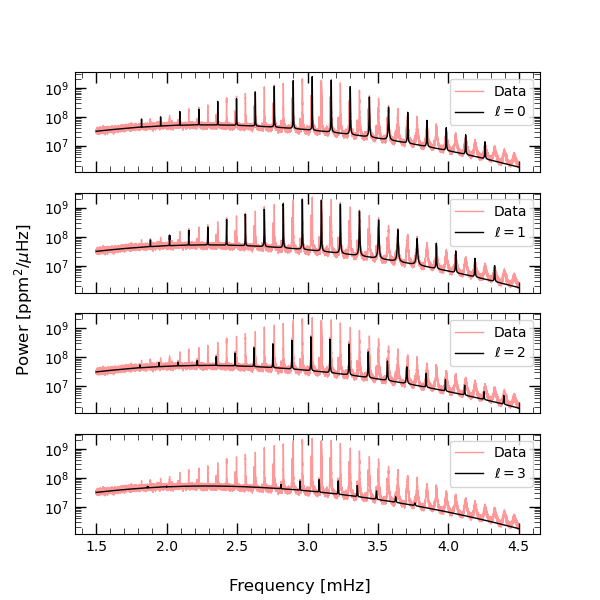

In [132]:
plt.close('all')
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(6, 6), sharex=True)
mask = (freq_mhz>1.5) * (freq_mhz<4.5)

axs[0].plot(freq_mhz[mask], pobs[mask], color='r', lw=1, alpha=0.4, label='Data')
axs[0].plot(freq_mhz[mask], psfit0[mask], 'k', lw=1, label='$\\ell=0$')
axs[0].set_yscale('log')
axs[0].legend()

axs[1].plot(freq_mhz[mask], pobs[mask], color='r', lw=1, alpha=0.4, label='Data')
axs[1].plot(freq_mhz[mask], psfit1[mask], 'k', lw=1, label='$\\ell=1$')
axs[1].set_yscale('log')
axs[1].legend()

axs[2].plot(freq_mhz[mask], pobs[mask], color='r', lw=1, alpha=0.4, label='Data')
axs[2].plot(freq_mhz[mask], psfit2[mask], 'k', lw=1, label='$\\ell=2$')
axs[2].set_yscale('log')
axs[2].legend()

axs[3].plot(freq_mhz[mask], pobs[mask], color='r', lw=1, alpha=0.4, label='Data')
axs[3].plot(freq_mhz[mask], psfit3[mask], 'k', lw=1, label='$\\ell=3$')
axs[3].set_yscale('log')
axs[3].legend()

fig.supxlabel('Frequency [mHz]')
fig.supylabel('Power [$\\mathrm{ppm}^2/\\mu$Hz]')
fig.savefig(f'{PAPDIR}/mi-filters.pdf')

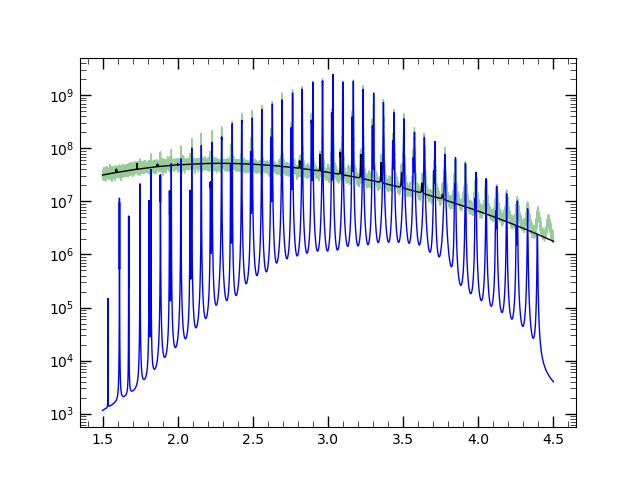

In [117]:
lsfit3 = ((amps_llk[:-2][mask0] @ pslbg2[:-2][mask0, :])*gfilter +
          (amps_llk[:-2][mask1] @ pslbg2[:-2][mask1, :])*gfilter +
          (amps_llk[:-2][mask2] @ pslbg2[:-2][mask2, :])*gfilter)

fig, ax = plt.subplots()
ax.plot(freq_mhz[mask], pobs[mask], color='green', lw=1, alpha=0.4, label='Data')
ax.plot(freq_mhz[mask], psfit3[mask], 'k', lw=1, label='$\\ell=3$')
ax.plot(freq_mhz[mask], lsfit3[mask], 'b', lw=1)
ax.set_yscale('log')

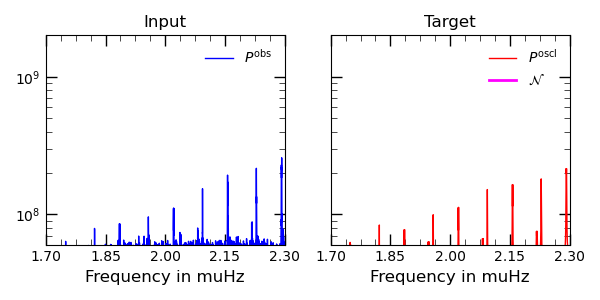

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 3), sharey=True)
mask = (freq_mhz>1.5) * (freq_mhz<4.5)
#__bgfit = amps[:-2] @ pslbg2[-2]
axs[0].plot(freq_mhz[mask], pobs[mask], color='b', lw=1, label='$P^\\mathrm{obs}$')
#axs[1].plot(freq_mhz[mask], pobs[mask], color='k', lw=1, alpha=0.3, label='$P^\\mathrm{obs}$')
axs[1].plot(freq_mhz[mask], ps3[mask], color='r', lw=1, label='$P^\\mathrm{oscl}$')
axs[1].plot(freq_mhz[mask], bgfit[mask], color='magenta', lw=2, label='$\\mathcal{N}$')
for _axs in axs: 
    _axs.legend(framealpha=0.)
    _axs.set_yscale('log')
    _axs.set_xlim([1.7, 2.3])
    _axs.set_ylim([6e7, 2e9])
    _axs.set_xlabel('Frequency in muHz', fontsize=12)
    _axs.set_xticks(np.linspace(1.7, 2.3, 5))
    
axs[0].set_title('Input')
axs[1].set_title('Target')
fig.tight_layout()
plt.savefig('/data/seismo/kashyap/brites-poster-transparent.png', dpi=1200, transparent=True)
plt.show()


In [15]:
dfreq = (freq_mhz[1]-freq_mhz[0])*1e3
print(f"The frequency resolution = {dfreq:.2f} muHz")

The frequency resolution = 0.07 muHz


# Only if kernels are loaded
print(f"Kernel shape = {kth.shape}")
print(f"axis=0: mode index\n" + 
      f"axis=1: emm+lmax (lmax=3)\n" + 
      f"axis=2: theta")

kernels_list = []
mask_list = [mask0, mask1, mask2, mask3]
for idx in range(4):
    elm = np.zeros(7)
    for emm in range(-idx, idx+1):
        elm[emm+3] = get_elm(idx, emm)
    _amplt = amps[:-2][mask_list[idx]][:, None, None] * elm[None, :, None]*1e-9
    _amplt = _amplt*_amplt
    _kernel = (kth[mask_list[idx]] * _amplt).sum(axis=0).sum(axis=0)
    kernels_list.append(_kernel)
kernels_list = np.array(kernels_list)
print(f"Shape of new kernels = {kernels_list.shape}")
print(f"axis=0: ell\n" +
      f"axis=1: theta")

## Computing the forward operator
The problem is linearized i.e. $A x = b$ where $A$ is the forward operator, $x$ is the unknown (B-spline coefficients corresponding to sound speed perturbation) and $b$ is the RHS vector ($\bar{\delta\nu}_\ell$). The forward operator is defined as 
$$ A_{j\ell} = \int \mathrm{d}\theta \sin\theta \; \mathcal{K}_\ell(\theta) B_j(\theta),$$
where $B_j(\theta)$ corresponds to B-spline basis.

th = np.linspace(0., np.pi, 360)
sinth = np.sin(th)
Am = np.zeros((4, bsp.shape[-1]))
for idx in range(4):
    Am[idx] = simps((kernels_list[idx][:, None])*bsp*(sinth[:, None]), x=th, axis=0)

# The multiplication by a small number is to prevent A.T @ A from being a large number
# Since the kernels need to be scaled to match with observations anyway, the scaling can be thought of as an adjustable parameter
plt.figure()
plt.plot(th*180/np.pi-90., kernels_list[0], label='$\mathcal{K}_0$')
plt.plot(th*180/np.pi-90., kernels_list[1], label='$\mathcal{K}_1$')
plt.plot(th*180/np.pi-90., kernels_list[2], label='$\mathcal{K}_2$')
plt.plot(th*180/np.pi-90., kernels_list[3], label='$\mathcal{K}_3$')
plt.legend()
plt.xlabel('Latitude')
plt.ylabel('Kernel magnitude')
plt.show()

In [16]:
# Computing the filtered power spectra
pmod0 = (amps_llk[:-2][mask0] @ pslbg2[:-2][mask0, :])*gfilter + bgfit
pmod1 = (amps_llk[:-2][mask1] @ pslbg2[:-2][mask1, :])*gfilter + bgfit
pmod2 = (amps_llk[:-2][mask2] @ pslbg2[:-2][mask2, :])*gfilter + bgfit
pmod3 = (amps_llk[:-2][mask3] @ pslbg2[:-2][mask3, :])*gfilter + bgfit

pexc0 = psfit0123 - (amps_llk[:-2][mask0] @ pslbg2[:-2][mask0, :])*gfilter - bgfit
pexc1 = psfit0123 - (amps_llk[:-2][mask1] @ pslbg2[:-2][mask1, :])*gfilter - bgfit
pexc2 = psfit0123 - (amps_llk[:-2][mask2] @ pslbg2[:-2][mask2, :])*gfilter - bgfit
pexc3 = psfit0123 - (amps_llk[:-2][mask3] @ pslbg2[:-2][mask3, :])*gfilter - bgfit

pfilt_list = [pmod0, pmod1, pmod2, pmod3]
pexcl_list = [pexc0, pexc1, pexc2, pexc3]
pfilt_list = np.array(pfilt_list)
pexcl_list = np.array(pexcl_list)

Text(0.02, 0.5, 'Power')

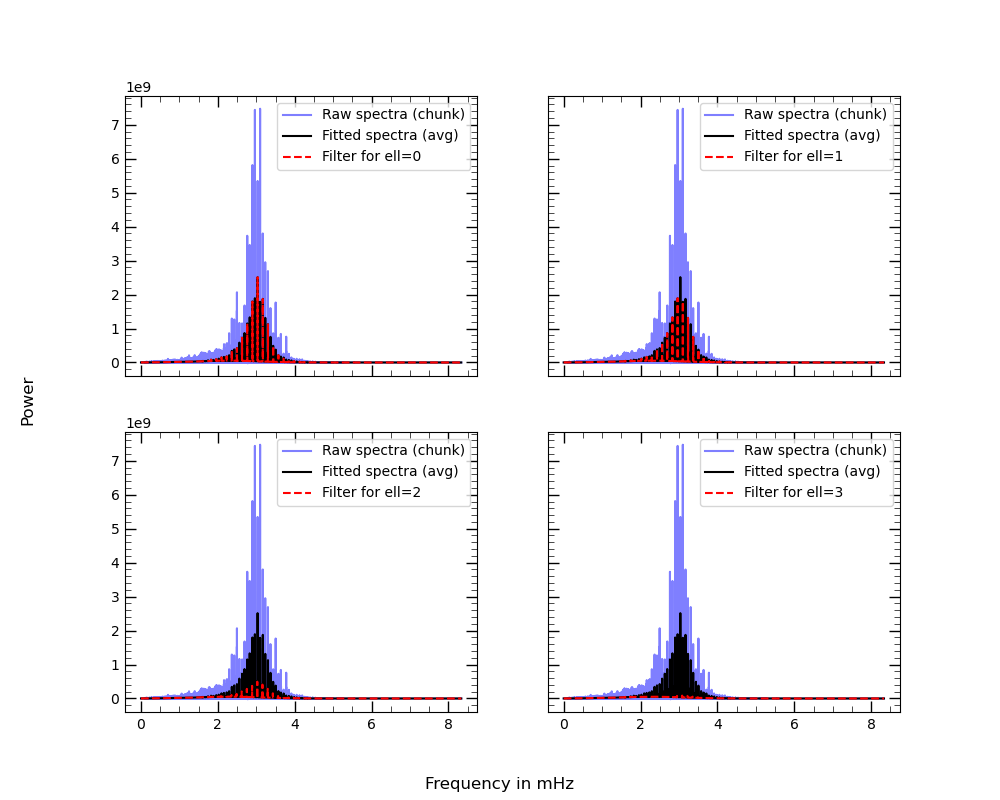

In [17]:
# Plotting all the filters
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10, 8))
axs = axs.flatten()
for _axs in axs:
    _axs.plot(freq_mhz, pschunks[0], 'b', alpha=0.5, label='Raw spectra (chunk)')
    _axs.plot(freq_mhz, psfit0123, 'k', label='Fitted spectra (avg)')

for idx in range(4):
    axs[idx].plot(freq_mhz, pfilt_list[idx], '--r', label=f'Filter for ell={idx}')
    axs[idx].legend()
fig.supxlabel('Frequency in mHz')
fig.supylabel('Power')

## Determining $\bar{\delta\nu}_\ell$
For each cross-correlation, the lag that maximizes the cross-correlation is found by fitting a Gaussian profile in the vicinity of the maxima. This is the procedure followed by Regulo et. al. (2016) A&A 589, A103. **Need to perform an analysis for determining the actual profile, but we'll stick with Gaussian for now.** 

Edit: After modelling the background variation, Gaussian model works fine for all filtered spectra

In [91]:
def get_freqlags_corrected(refarr, pfilt_list, pexcl_list, maxlag=20):
    # print(f"max frequency lag = {maxlag*dfreq:.2f} muHz")
    
    # corr_mat stores the correlation matrix [ell, time_chunk, lag]
    # corr_mat_gauss stores the gaussian fit [ell, time_chunk, lag]
    # corr_matarg stores the index corresponding to maximum corr [ell, time_chunk]
    # corr_matarg_gauss max corr for the gaussian fit [ell, time_chunk]
    
    corr_mat = np.zeros((4, 2*maxlag+1))
    corr_mat_gauss = np.zeros((4, 2*maxlag+1))
    corr_matarg = np.zeros(4)
    corr_matarg_gauss = np.zeros(4)
    
    lags_list, corr_list, corrnlist, corrbg_list = [], [], [], []
    for jdx in range(pfilt_list.shape[0]):
        p0 = [1., 0., 1., 0.]
        coeff = [0., 0., 0., 0.]
        lags, corr = compute_cc(pfilt_list[jdx]/1e10, refarr/1e10, maxlag=maxlag)
        lags_bg, corr_bg = compute_cc(pexcl_list[jdx]/1e10, pfilt_list[jdx]/1e10, maxlag=maxlag)
        corr = corr + corr_bg
        try:
            coeff, var_matrix = curve_fit(gaussian, lags, corr, p0=p0)
        except RuntimeError:
            coeff[1] = np.nan
        corr_mat_gauss[jdx, :] = gaussian(lags, *coeff)
        corr_mat[jdx, :] = corr
        max_idx = np.argmax(corr)
        corr_matarg[jdx] = lags[max_idx]
        corr_matarg_gauss[jdx] = coeff[1]
        corrbg_list.append(corr_bg)
    return (corr_mat, corr_mat_gauss), (corr_matarg, corr_matarg_gauss), corrbg_list


def get_freqlags_corrected2(refarr, pfilt_list, pexcl_list, maxlag=20):
    # print(f"max frequency lag = {maxlag*dfreq:.2f} muHz")
    
    # corr_mat stores the correlation matrix [ell, time_chunk, lag]
    # corr_mat_gauss stores the gaussian fit [ell, time_chunk, lag]
    # corr_matarg stores the index corresponding to maximum corr [ell, time_chunk]
    # corr_matarg_gauss max corr for the gaussian fit [ell, time_chunk]
    
    corr_mat = np.zeros((4, 2*maxlag+1))
    corr_mat_gauss = np.zeros((4, 2*maxlag+1))
    corr_matarg = np.zeros(4)
    corr_matarg_gauss = np.zeros(4)
    
    lags_list, corr_list, corrnlist, corrbg_list = [], [], [], []
    for jdx in range(pfilt_list.shape[0]):
        p0 = [1., 0., 1., 0.]
        lags, corr = compute_cc(pfilt_list[jdx]/1e10, refarr/1e10, maxlag=maxlag)
        lags_bg, corr_bg = compute_cc(pexcl_list[jdx]/1e10, refarr/1e10, maxlag=maxlag)
        corr = corr - corr_bg
        try:
            coeff, var_matrix = curve_fit(gaussian, lags, corr, p0=p0)
        except RuntimeError:
            coeff[1] = 0.
        corr_mat_gauss[jdx, :] = gaussian(lags, *coeff)
        corr_mat[jdx, :] = corr
        max_idx = np.argmax(corr)
        corr_matarg[jdx] = lags[max_idx]
        corr_matarg_gauss[jdx] = coeff[1]
        corrbg_list.append(corr_bg)
    return (corr_mat, corr_mat_gauss), (corr_matarg, corr_matarg_gauss), corrbg_list

max frequency lag = 1.84 muHz


Time index=: 100%|██████████| 102/102 [00:05<00:00, 19.47it/s]


Text(0.02, 0.5, '$\\bar{\\delta\\nu}_\\ell$ in $\\mu$Hz')

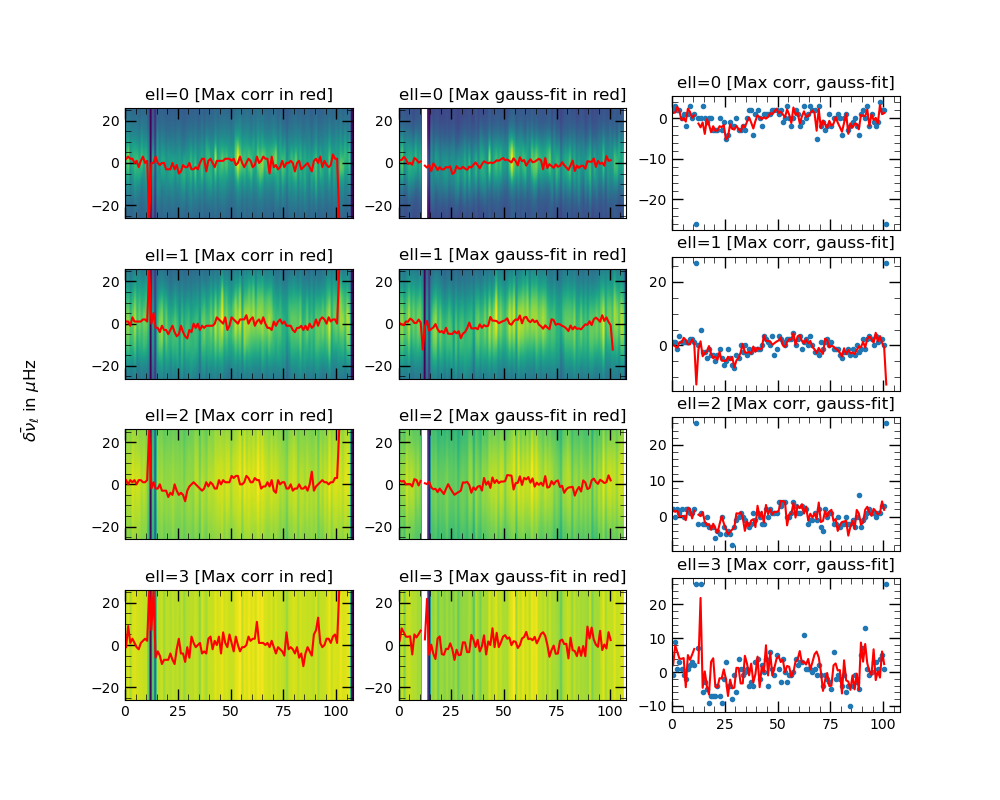

In [19]:
maxlag = 26
p0 = [1., 0., 1., 0.]
print(f"max frequency lag = {maxlag*dfreq:.2f} muHz")
lags = np.arange(-maxlag, maxlag+1)

# corr_mat stores the correlation matrix [ell, time_chunk, lag]
# corr_mat_gauss stores the gaussian fit [ell, time_chunk, lag]
# corr_matarg stores the index corresponding to maximum corr [ell, time_chunk]
# corr_matarg_gauss max corr for the gaussian fit [ell, time_chunk]

corr_mat = np.zeros((4, pschunks.shape[0], 2*maxlag+1))
corr_mat_gauss = np.zeros((4, pschunks.shape[0], 2*maxlag+1))
corr_matarg = np.zeros((4, pschunks.shape[0]))
corr_matarg_gauss = np.zeros((4, pschunks.shape[0]))

for idx in tqdm(range(pschunks.shape[0]), desc="Time index=", leave=True):
    lags_list, corr_list, corrnlist = [], [], []
    (_cm, _cmg), (_cma, _cmag), _cbg_list = get_freqlags_corrected(pschunks[idx], pfilt_list, pexcl_list, maxlag=maxlag)
    corr_mat[:, idx, :] = _cm
    corr_mat_gauss[:, idx, :] = _cmg
    corr_matarg[:, idx] = _cma
    corr_matarg_gauss[:, idx] = _cmag


xax = np.arange(pschunks.shape[0])
fig, axs = plt.subplots(nrows=4, ncols=3, sharex=True, figsize=(10, 8))
axs[0, 0].imshow(corr_mat[0].T, extent=[0, 108, -maxlag, maxlag,], origin='lower'); axs[0, 0].plot(xax+0.5, corr_matarg[0], 'r')
axs[1, 0].imshow(corr_mat[1].T, extent=[0, 108, -maxlag, maxlag,], origin='lower'); axs[1, 0].plot(xax+0.5, corr_matarg[1], 'r')
axs[2, 0].imshow(corr_mat[2].T, extent=[0, 108, -maxlag, maxlag,], origin='lower'); axs[2, 0].plot(xax+0.5, corr_matarg[2], 'r')
axs[3, 0].imshow(corr_mat[3].T, extent=[0, 108, -maxlag, maxlag,], origin='lower'); axs[3, 0].plot(xax+0.5, corr_matarg[3], 'r')

axs[0, 1].imshow(corr_mat_gauss[0].T, extent=[0, 108, -maxlag, maxlag,], origin='lower'); axs[0, 1].plot(xax+0.5, corr_matarg_gauss[0], 'r')
axs[1, 1].imshow(corr_mat_gauss[1].T, extent=[0, 108, -maxlag, maxlag,], origin='lower'); axs[1, 1].plot(xax+0.5, corr_matarg_gauss[1], 'r')
axs[2, 1].imshow(corr_mat_gauss[2].T, extent=[0, 108, -maxlag, maxlag,], origin='lower'); axs[2, 1].plot(xax+0.5, corr_matarg_gauss[2], 'r')
axs[3, 1].imshow(corr_mat_gauss[3].T, extent=[0, 108, -maxlag, maxlag,], origin='lower'); axs[3, 1].plot(xax+0.5, corr_matarg_gauss[3], 'r')

axs[0, 2].plot(xax+0.5, corr_matarg[0], '.'); axs[0, 2].plot(xax+0.5, corr_matarg_gauss[0], '-r')
axs[1, 2].plot(xax+0.5, corr_matarg[1], '.'); axs[1, 2].plot(xax+0.5, corr_matarg_gauss[1], '-r')
axs[2, 2].plot(xax+0.5, corr_matarg[2], '.'); axs[2, 2].plot(xax+0.5, corr_matarg_gauss[2], '-r')
axs[3, 2].plot(xax+0.5, corr_matarg[3], '.'); axs[3, 2].plot(xax+0.5, corr_matarg_gauss[3], '-r')
for idx in range(4): 
    axs[idx, 0].set_title(f'ell={idx} [Max corr in red]')
    axs[idx, 1].set_title(f'ell={idx} [Max gauss-fit in red]')
    axs[idx, 2].set_title(f'ell={idx} [Max corr, gauss-fit]')
fig.supylabel('$\\bar{\\delta\\nu}_\\ell$ in $\\mu$Hz')

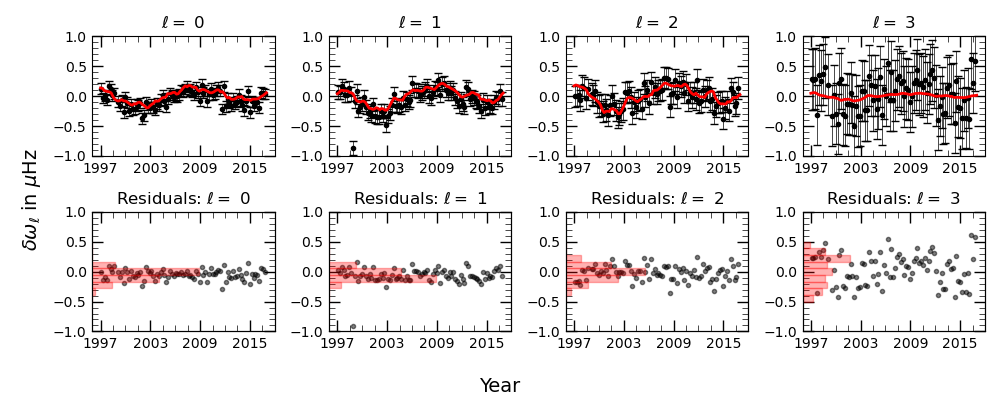

In [20]:
# Preliminary analysis
# Need to reperform this with correct values
from scipy.interpolate import interp1d
howe_nus = np.load('/scratch/seismo/kashyap/data/delnu-obs-howe.npy')
howe_ell = np.load('/scratch/seismo/kashyap/processed/sun-intg/ps-fits/valeriy-red-Ncarr3-skip60-ell3-i86/fitted-ell-list.npy')
howe_gamma = np.load('/scratch/seismo/kashyap/processed/sun-intg/ps-fits/valeriy-red-Ncarr3-skip60-ell3-i86/fitted-gamma-list.npy')
howe_nus[np.isnan(howe_nus)] = 0.
howe_mask0 = howe_ell==0
howe_mask1 = howe_ell==1
howe_mask2 = howe_ell==2
howe_mask3 = howe_ell==3
howe_yrs = np.linspace(1997, 2017, howe_nus.shape[-1])
howe_masklist = [howe_mask0, 
                 howe_mask1, 
                 howe_mask2,
                 howe_mask3]

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(10, 4),)
sig0 = 0.090
sig1 = 0.116
sig2 = 0.178
sig3 = 0.507
yerr_list = [sig0, sig1, sig2, sig3]
common_yrs_min = max(YRS.min(), howe_yrs.min())
common_yrs_max = min(YRS.max(), howe_yrs.max())
mask_hyrs = (howe_yrs<=common_yrs_max)*(howe_yrs>=common_yrs_min)
mask_yrs = (YRS<common_yrs_max)*(YRS>common_yrs_min)
_abyg = amps_llk[:-2]#/howe_gamma**1.5
_abyg2 = amps_llk[:-2]**2/howe_gamma
_abyg = _abyg/_abyg.max()
_abyg2 = _abyg2/_abyg2.max()
for idx in range(4):
    #axs[idx].plot(YRS, corr_matarg_gauss[idx]*dfreq, '+k',)
    axs[0, idx].errorbar(YRS[mask_yrs], corr_matarg_gauss[idx][mask_yrs]*dfreq, yerr=np.ones_like(YRS[mask_yrs])*yerr_list[idx], capsize=3, color='k', marker='o', markersize=3, linestyle='', lw=0.5)
    #axs[idx].plot(howe_yrs, -howe_nus[howe_masklist[idx], :].mean(axis=0)*1e-3, 'b', lw=2, alpha=0.5)
    #lamps = (_amps_norm[howe_masklist[idx]])**2 / (howe_gamma[howe_masklist[idx]]**3)
    #lamps = _abyg[howe_masklist[idx]]**2
    lamps = _abyg2[howe_masklist[idx]]
    axs[0, idx].plot(howe_yrs[mask_hyrs], - lamps @ howe_nus[howe_masklist[idx], :][:, mask_hyrs]*1e-3/lamps.sum(), 'r', lw=2, zorder=4)
    axs[0, idx].set_xticks(np.arange(1997, 2020, 6))
    axs[0, idx].set_ylim([-1, 1])
    axs[0, idx].set_title('$\\ell=$ '+f'{idx}')

    ival = interp1d(howe_yrs[mask_hyrs], lamps @ howe_nus[howe_masklist[idx], :][:, mask_hyrs]*1e-3/lamps.sum())
    delnu_howe = ival(YRS[mask_yrs])

    #axs[1, idx].errorbar(YRS[mask_yrs], corr_matarg_gauss[idx][mask_yrs]*dfreq + delnu_howe, yerr=np.ones_like(YRS[mask_yrs])*yerr_list[idx], capsize=3, color='k', marker='o', markersize=3, linestyle='', lw=0.5)
    axs[1, idx].plot(YRS[mask_yrs], corr_matarg_gauss[idx][mask_yrs]*dfreq + delnu_howe, color='k', marker='o', markersize=3, 
                     linestyle='', lw=0.5, alpha=0.5)
    axs[1, idx].set_xticks(np.arange(1997, 2020, 6))
    axs[1, idx].set_ylim([-1, 1])
    axs[1, idx].set_title('Residuals: $\\ell=$ '+f'{idx}')

    ax2 = axs[1, idx].twinx()
    ax2.set(yticklabels=[])
    
    # Plot the histogram on the second y-axis
    bins = np.linspace(-0.5, 0.5, 10)
    n, bins, patches = ax2.hist((corr_matarg_gauss[idx][mask_yrs]*dfreq + delnu_howe), bins=bins, 
                                orientation='horizontal', color='r', alpha=0.3, edgecolor='r')
    for patch in patches:
        patch.set_x(patch.get_x() + 1996)
        patch.set_width(patch.get_width()*0.3)
    axs[1, idx].set_xlim([1996, 2018])
    ax2.set_ylim([-1, 1])

    #axs[2, idx].hist((corr_matarg_gauss[idx][mask_yrs]*dfreq + delnu_howe)/yerr_list[idx], bins=np.linspace(-3, 3, 20), color='k', alpha=0.4)
fig.supxlabel('Year', fontsize=14)
fig.supylabel('$\\delta\\omega_\\ell$ in $\\mu$Hz', fontsize=14)
fig.tight_layout()
fig.savefig('/home/kashyap/Downloads/delnu-ell-bison-xl.png')

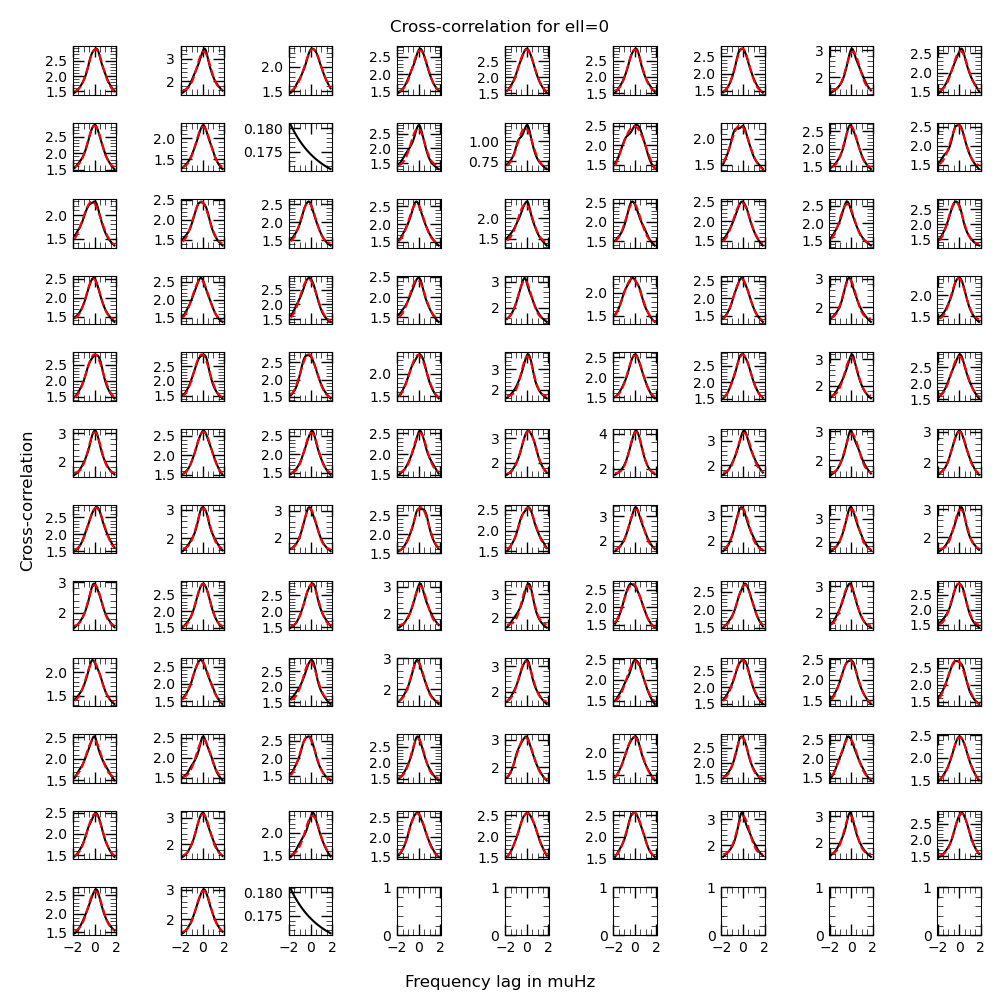

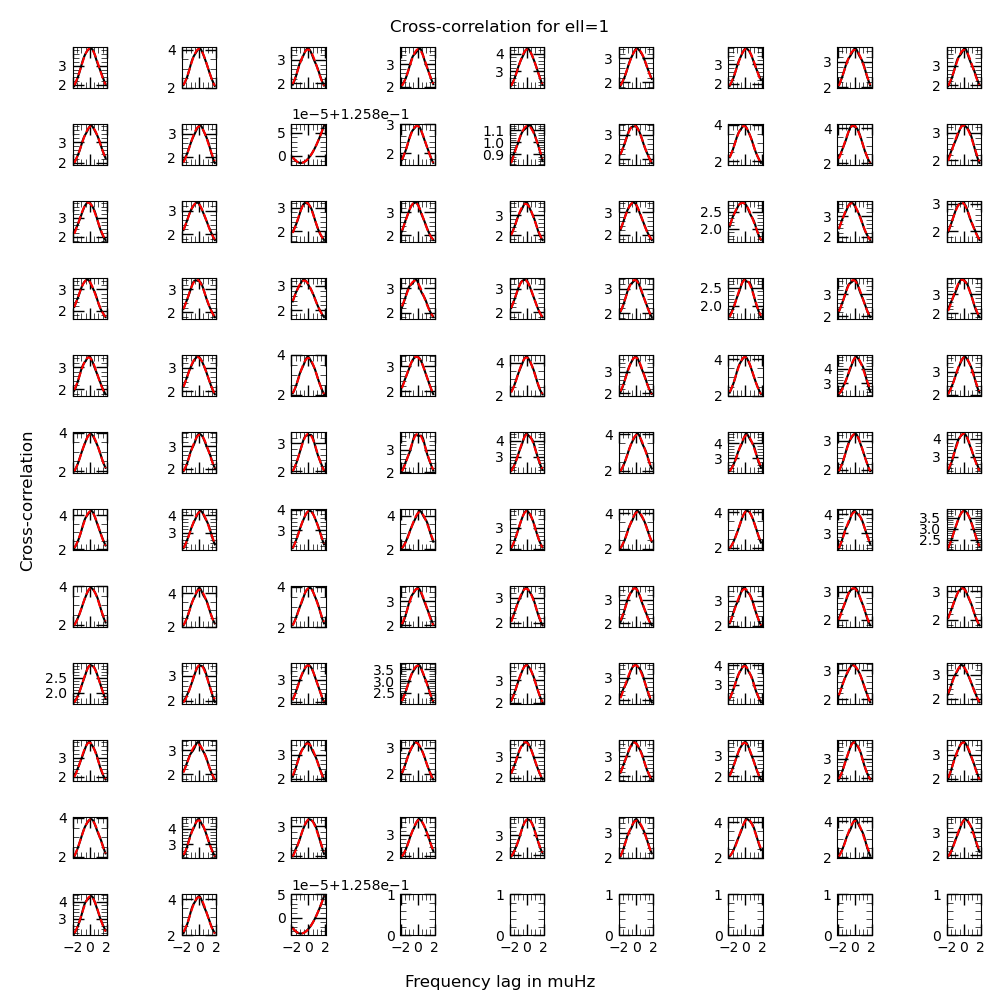

Error in callback <function flush_figures at 0x14cf3202a0d0> (for post_execute):


In [ ]:
for idx in range(4):
    fig, axs = plt.subplots(nrows=12, ncols=9, sharex=True, figsize=(10, 10))
    axs = axs.flatten()
    for jdx in range(corr_mat_gauss.shape[1]):
        axs[jdx].plot(lags*dfreq, corr_mat[idx, jdx], 'k')
        axs[jdx].plot(lags*dfreq, corr_mat_gauss[idx, jdx], '--r')
    fig.supxlabel('Frequency lag in muHz')
    fig.supylabel('Cross-correlation')
    fig.suptitle(f'Cross-correlation for ell={idx}')
    fig.tight_layout()

In [26]:
plt.close('all')

In [ ]:
op_list = []
for idx in range(108):
    op = solve_inv_prob(Am, corr_matarg_gauss[:, idx], regval=3.e1)
    op_list.append(op)
op_list = np.array(op_list)
plt.figure(figsize=(6, 2))
im = plt.imshow(-op_list.T + op_list[~np.isnan(op_list)].max(), extent=[0, 108, -90, 90], aspect='auto')
plt.colorbar(im)

In [ ]:
plt.figure(figsize=(6, 2))
im = plt.imshow(-op_list.T + op_list[~np.isnan(op_list)].max(), extent=[0, 108, -90, 90], aspect='auto')
plt.colorbar(im)

In [ ]:
import logging
from regpy.hilbert import L2
from regpy.solvers import RegularizationSetting, TikhonovRegularizationSetting
from regpy.solvers.linear.tikhonov import TikhonovCG, TikhonovAlphaGrid, NonstationaryIteratedTikhonov
from regpy.solvers.nonlinear.fista import FISTA
import regpy.stoprules as rules
from regpy.functionals import L1#, QuadraticNonneg                                                    

from regpy.operators import MatrixMultiplication
from regpy.vecsps import UniformGridFcts

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s %(levelname)s %(name)-20s :: %(message)s'
)

grid = UniformGridFcts(np.linspace(0, 14, 15))

covmat = np.identity(Am.shape[0])
fwd = Am*1.0
rhs = corr_matarg_gauss

U, V = np.linalg.eigh(covmat)

epsilon=1e-10
U_inv=np.zeros((4))
for i in range(0, 4):
    if U[i]>epsilon:
        U_inv[i]=1/np.sqrt(U[i])

cov_inv = (V.T.conj()*U_inv).dot(V)
cov_inv = V.T.conj()*(1/(np.sqrt(U+1e-2))).dot(V)

op = MatrixMultiplication(cov_inv.dot(fwd), domain=grid)

In [ ]:
reco_arr = np.zeros((15, 108))
reco_data_arr = np.zeros((4, 108))

penalty=L1
#penalty=QuadraticNonneg(op.domain)                                         

setting = TikhonovRegularizationSetting(op=op, penalty=penalty, data_fid=L2)
noiselevel = 1.
alpha = 3e1

for i in range(0, 108):
    data=cov_inv.dot(rhs[:, i])
    solver = TikhonovCG(setting, data, alpha, logging_level=logging.CRITICAL,
                        tol=0.01*noiselevel/np.sqrt(alpha),
                        all_tol_criteria=False)
    stoprule = rules.CountIterations(max_iterations=10)
    reco, reco_data = solver.run(stoprule)
    reco_arr[:, i]=reco.copy()
    reco_data_arr[:, i]=reco_data.copy()


In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6, 6), sharex=True)
inv1 = -reco_arr + reco_arr[~np.isnan(reco_arr)].max()
inv2 = -op_list.T + op_list[~np.isnan(op_list)].max()
vmax = abs(inv2)[~np.isnan(inv2)].max()
im0 = axs[0].imshow(inv1, aspect='auto', extent=[years.min(), years.max(), -90, 90], vmax=vmax, vmin=0.)
im1 = axs[1].imshow(inv2, aspect='auto', extent=[years.min(), years.max(), -90, 90], vmax=vmax, vmin=0.)
im2 = axs[2].imshow(abs(inv1-inv2), aspect='auto', extent=[years.min(), years.max(), -90, 90], vmax=vmax/1, vmin=0.)
axs[0].set_title('Inversion (itreg)')
axs[1].set_title('Inversion (mine)')
axs[2].set_title('|difference|')
axs[2].set_xticks(np.arange(1998, 2017, 3))
for _axs in axs: _axs.set_yticks(np.arange(-90, 91, 30))
plt.colorbar(im0, ax=axs[0])
plt.colorbar(im1, ax=axs[1])
plt.colorbar(im2, ax=axs[2])
fig.supylabel('Latitude')
fig.tight_layout()

### Understand errors using Monte-Carlo simulations
- Fix observation times: 30d, 90d, 180d
- Inject $\delta\nu_{n\ell m}$ into spectra
- Test recovery using 1000 different models
- Plot histograms for each case

# Case0: Existing data - 76.2d observations (3 Carr)
- Case0a: Constant $\delta\nu$ across different $n$
- Case0b: $\delta\nu$ according to model (using kernels) -- compare with simple average and weighted average
$$ \bar{\delta\nu}_1 = \sum_{n m}\delta\nu_{n\ell m}$$
$$ \bar{\delta\nu}_2 = \sum_{n m}A_{n\ell m} \delta\nu_{n\ell m}$$

- **Needs proper derivation to understand what quantity is measured by cross correlation technique**


In [27]:
# Computing shifted power spectra
shiftval_list = [5, 10, 15, 20]
shiftval = -shiftval_list[0]
print(f"Defined delnu = {shiftval*dfreq:.2f} muHz")
pmod0s = (amps_llk[:-2][mask0] @ np.roll(pslbg2[:-2][mask0, :], shiftval, axis=1))*gfilter + psfit123
pmod1s = (amps_llk[:-2][mask1] @ np.roll(pslbg2[:-2][mask1, :], shiftval, axis=1))*gfilter + psfit023
pmod2s = (amps_llk[:-2][mask2] @ np.roll(pslbg2[:-2][mask2, :], shiftval, axis=1))*gfilter + psfit013
pmod3s = (amps_llk[:-2][mask3] @ np.roll(pslbg2[:-2][mask3, :], shiftval, axis=1))*gfilter + psfit012

Defined delnu = -0.35 muHz


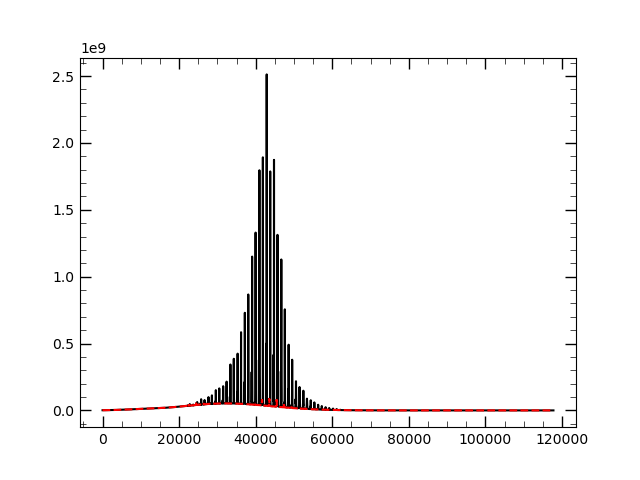

In [28]:
plt.figure()
plt.plot(pmod3s, 'k')
plt.plot(pfilt_list[-1], '--r')
plt.show()

In [92]:
def get_freqlags(refarr, pfilt_list, maxlag=20):
    # print(f"max frequency lag = {maxlag*dfreq:.2f} muHz")
    
    # corr_mat stores the correlation matrix [ell, time_chunk, lag]
    # corr_mat_gauss stores the gaussian fit [ell, time_chunk, lag]
    # corr_matarg stores the index corresponding to maximum corr [ell, time_chunk]
    # corr_matarg_gauss max corr for the gaussian fit [ell, time_chunk]
    
    corr_mat = np.zeros((4, 2*maxlag+1))
    corr_mat_gauss = np.zeros((4, 2*maxlag+1))
    corr_matarg = np.zeros(4)
    corr_matarg_gauss = np.zeros(4)
    
    lags_list, corr_list, corrnlist, corrbg_list = [], [], [], []
    for jdx in range(pfilt_list.shape[0]):
        p0 = [1., 0., 1., 0.]
        lags, corr = compute_cc(pfilt_list[jdx]/1e10, refarr/1e10, maxlag=maxlag)
        try:
            coeff, var_matrix = curve_fit(gaussian, lags, corr, p0=p0)
        except RuntimeError:
            coeff[1] = 0.
        corr_mat_gauss[jdx, :] = gaussian(lags, *coeff)
        corr_mat[jdx, :] = corr
        max_idx = np.argmax(corr)
        corr_matarg[jdx] = lags[max_idx]
        corr_matarg_gauss[jdx] = coeff[1]
    return (corr_mat, corr_mat_gauss), (corr_matarg, corr_matarg_gauss)


In [32]:
collect0fitval = []
collect1fitval = []
collect2fitval = []
collect3fitval = []
for idx in tqdm(range(1000), desc='performing Montecarlo'):
    __a0, __a00 = get_freqlags(noisify(pmod0s), pfilt_list)
    __a1, __a10 = get_freqlags(noisify(pmod1s), pfilt_list)
    __a2, __a20 = get_freqlags(noisify(pmod2s), pfilt_list)
    __a3, __a30 = get_freqlags(noisify(pmod3s), pfilt_list)
    collect0fitval.append(__a00[1][0])
    collect1fitval.append(__a10[1][1])
    collect2fitval.append(__a20[1][2])
    collect3fitval.append(__a30[1][3])

collect0fitval = np.array(collect0fitval)
collect1fitval = np.array(collect1fitval)
collect2fitval = np.array(collect2fitval)
collect3fitval = np.array(collect3fitval)

performing Montecarlo:   3%|▎         | 28/1000 [00:02<01:39,  9.82it/s]/tmp/ipykernel_45619/2066549737.py:19: OptimizeWarning: Covariance of the parameters could not be estimated
  coeff, var_matrix = curve_fit(gaussian, lags, corr, p0=p0)
performing Montecarlo: 100%|██████████| 1000/1000 [01:42<00:00,  9.80it/s]


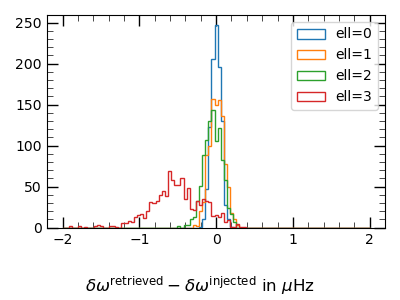

In [33]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(4, 3))
axs.hist((collect0fitval + shiftval)*dfreq, histtype=u'step', label='ell=0', bins=np.linspace(-2, 2, 100))
axs.hist((collect1fitval + shiftval)*dfreq, histtype=u'step', label='ell=1', bins=np.linspace(-2, 2, 100))
axs.hist((collect2fitval + shiftval)*dfreq, histtype=u'step', label='ell=2', bins=np.linspace(-2, 2, 100))
axs.hist((collect3fitval + shiftval)*dfreq, histtype=u'step', label='ell=3', bins=np.linspace(-2, 2, 100))
fig.supxlabel('$\\delta\\omega^\\mathrm{retrieved} - \\delta\\omega^\\mathrm{injected}$ in $\\mu$Hz', fontsize=12)
axs.legend()
fig.tight_layout()

In [154]:
import h5py

with h5py.File('/data/seismo/kashyap/codes/p11-seismo-xl/data/test.h5', 'w') as f:
    f.create_dataset('pfilt0', data=pfilt_list[0])
    f.create_dataset('pfilt1', data=pfilt_list[1])
    f.create_dataset('pfilt2', data=pfilt_list[2])
    f.create_dataset('pfilt3', data=pfilt_list[3])
    f.create_dataset('pmod0s', data=pmod0s)
    f.create_dataset('pmod1s', data=pmod1s)
    f.create_dataset('pmod2s', data=pmod2s)
    f.create_dataset('pmod3s', data=pmod3s)
    

tfile = h5py.File('/data/seismo/kashyap/codes/p11-seismo-xl/data/test.h5')

### systematic shift seen in $\delta\nu$ for $\ell=2, 3$ -- this needs to be understood
- Masking low frequency components does not change the distribution of the output
- This is because of profile used to fit. A gaussian profile is assumed, but it is clearly seen that the profile in the autocorrelation function is asymmetric about the centroid.
- **This means that using the correct profile is critical for removing systematic biases -- hence the derivation of the correct profile is critical**

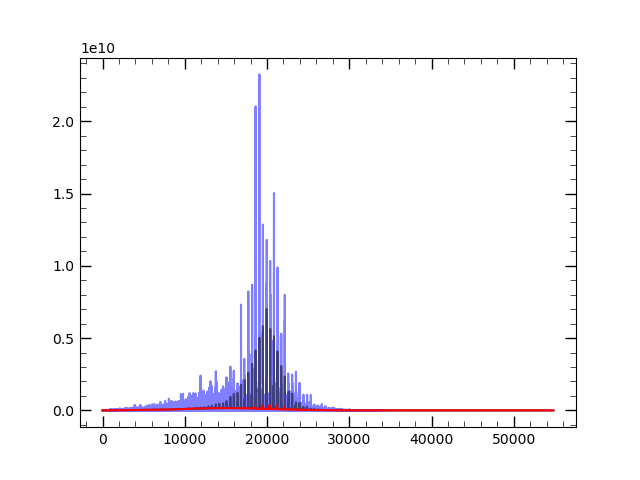

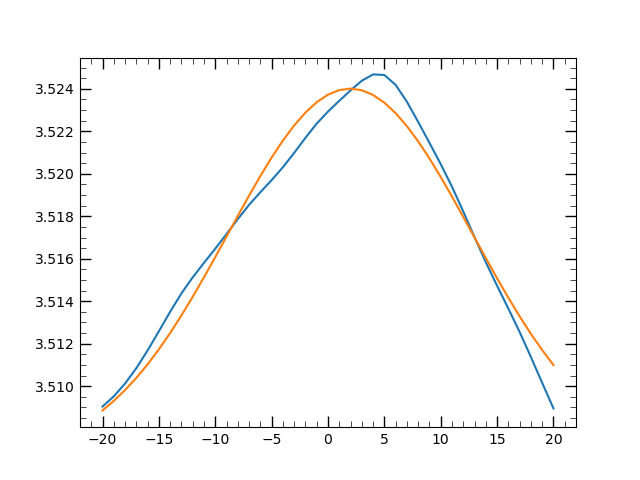

In [38]:
plt.figure()
plt.plot(noisify(pmod3s), 'b', alpha=0.5)
plt.plot(pmod3s, 'k', alpha=0.5)
plt.plot(pfilt_list[-1], 'r')

__a3, __a30 = get_freqlags(pmod3s, pfilt_list)
plt.figure()
plt.plot(np.arange(-20, 21), __a3[0][3])
plt.plot(np.arange(-20, 21), __a3[1][3])

### Understanding cross-correlation function for a lorentzian

In [39]:
def lorentzian(x, mu, gamma):
    dxg = (x-mu)/(gamma/2)
    lor = 1./(1. + dxg**2)
    return lor

Text(0.5, 0, 'Frequency lag in $\\mu$Hz')

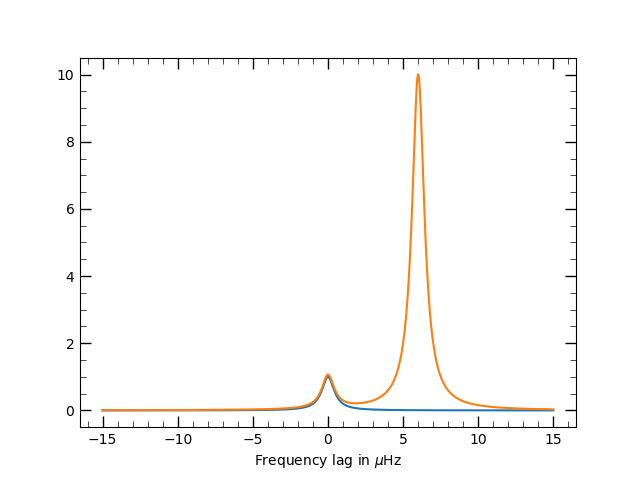

In [40]:
x = np.linspace(-15, 15, 1000)
dx = x[1] - x[0]
plt.figure()
bgtest = 10*lorentzian(x, 6, 1)
lor1 = lorentzian(x, 0., 1.) #+ 20*lorentzian(x, 3, 1)
lor2 = lorentzian(x, 0.0, 1.) + bgtest
plt.plot(x, lor1)
plt.plot(x, lor2)
plt.xlabel('Frequency lag in $\\mu$Hz')

In [41]:
p0 = [1., 0., 1., 0.]
lags, corr = compute_cc(lor1, lor2, maxlag=50)
lags2, corr2 = compute_cc(lor1, bgtest, maxlag=50)
_sidx = 0.6/dx

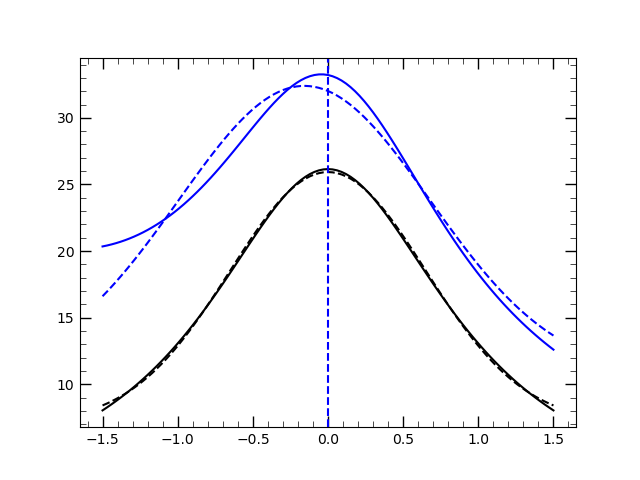

In [42]:
coeff1, var_matrix = curve_fit(gaussian, lags, corr, p0=p0)
coeff1c, var_matrix = curve_fit(gaussian, lags, corr-corr2, p0=p0)

plt.figure()
plt.plot(lags*dx, corr, 'b')
plt.plot(lags*dx, gaussian(lags, *coeff1), '--b')
plt.plot(lags*dx, corr-corr2, 'k')
plt.plot(lags*dx, gaussian(lags, *coeff1c), '--k')
plt.axvline(x=0., color='b', linestyle='dashed')
plt.show()

- **Asymmetry in the misfit exists because of asymmetry in the background**
- As seen in the above figure, fitting a gaussian to the above profile leads to wrong estimation of peak
- Need a model for the background (sum of non-seismic background and larger amplitude modes)
- We can set this up like this:
$$ \mathcal{P}_\ell(\omega) = P_\mathrm{background}(\omega) + \sum_{n m} A_{n\ell m} L(\omega, \omega_{n\ell m}, \Gamma_{n\ell})$$
$$ \mathcal{B}_\ell(\omega) = \sum_{n \ell' m; \ell'\neq \ell} A_{n\ell' m} L(\omega, \omega_{n\ell' m}, \Gamma_{n\ell'}) $$
Using this, the cross-correlation function baseline can be derived to be
$$ \bar{\delta\nu}_\ell^b = \langle \mathcal{P}_\ell(\omega), \mathcal{B}_\ell(\omega) \rangle $$
This needs to be removed from the observed cross-correlation
$$ \bar{\delta\nu}_\ell = \langle \mathcal{P}_\ell(\omega), P^\mathrm{obs}(\omega)\rangle $$

In [93]:
def get_freqlags_corrected(refarr, pfilt_list, maxlag=20, corrtype=1):
    # print(f"max frequency lag = {maxlag*dfreq:.2f} muHz")
    
    # corr_mat stores the correlation matrix [ell, time_chunk, lag]
    # corr_mat_gauss stores the gaussian fit [ell, time_chunk, lag]
    # corr_matarg stores the index corresponding to maximum corr [ell, time_chunk]
    # corr_matarg_gauss max corr for the gaussian fit [ell, time_chunk]
    
    corr_mat = np.zeros((4, 2*maxlag+1))
    corr_mat_gauss = np.zeros((4, 2*maxlag+1))
    corr_matarg = np.zeros(4)
    corr_matarg_gauss = np.zeros(4)
    
    lags_list, corr_list, corrnlist, corrbg_list = [], [], [], []
    for jdx in range(pfilt_list.shape[0]):
        p0 = [1., 0., 1., 0.]
        lags, corr = compute_cc(pfilt_list[jdx]/1e10, refarr/1e10, maxlag=maxlag)
        if corrtype==1: 
            lags_bg, corr_bg = compute_cc(pexcl_list[jdx]/1e10, pfilt_list[jdx]/1e10, maxlag=maxlag)
            corr = corr + corr_bg
        else:
            lags_bg, corr_bg = compute_cc(pexcl_list[jdx]/1e10, refarr/1e10, maxlag=maxlag)
            corr = corr - corr_bg

        try:
            coeff, var_matrix = curve_fit(gaussian, lags, corr, p0=p0)
        except RuntimeError:
            coeff[1] = 0.
        corr_mat_gauss[jdx, :] = gaussian(lags, *coeff)
        corr_mat[jdx, :] = corr
        max_idx = np.argmax(corr)
        corr_matarg[jdx] = lags[max_idx]
        corr_matarg_gauss[jdx] = coeff[1]
        corrbg_list.append(corr_bg)
    return (corr_mat, corr_mat_gauss), (corr_matarg, corr_matarg_gauss), corrbg_list

In [56]:
collect0fitval_corr = []
collect1fitval_corr = []
collect2fitval_corr = []
collect3fitval_corr = []
for idx in tqdm(range(1000), desc='performing Montecarlo'):
    __a0, __a00, cbg0 = get_freqlags_corrected(noisify(pmod0s), pfilt_list)
    __a1, __a10, cbg1 = get_freqlags_corrected(noisify(pmod1s), pfilt_list)
    __a2, __a20, cbg2 = get_freqlags_corrected(noisify(pmod2s), pfilt_list)
    __a3, __a30, cbg3 = get_freqlags_corrected(noisify(pmod3s), pfilt_list)
    collect0fitval_corr.append(__a00[1][0])
    collect1fitval_corr.append(__a10[1][1])
    collect2fitval_corr.append(__a20[1][2])
    collect3fitval_corr.append(__a30[1][3])

collect0fitval_corr = np.array(collect0fitval_corr)
collect1fitval_corr = np.array(collect1fitval_corr)
collect2fitval_corr = np.array(collect2fitval_corr)
collect3fitval_corr = np.array(collect3fitval_corr)

performing Montecarlo:   0%|          | 1/1000 [00:00<02:53,  5.75it/s]/tmp/ipykernel_45619/2445068108.py:26: OptimizeWarning: Covariance of the parameters could not be estimated
  coeff, var_matrix = curve_fit(gaussian, lags, corr, p0=p0)
performing Montecarlo: 100%|██████████| 1000/1000 [02:51<00:00,  5.82it/s]


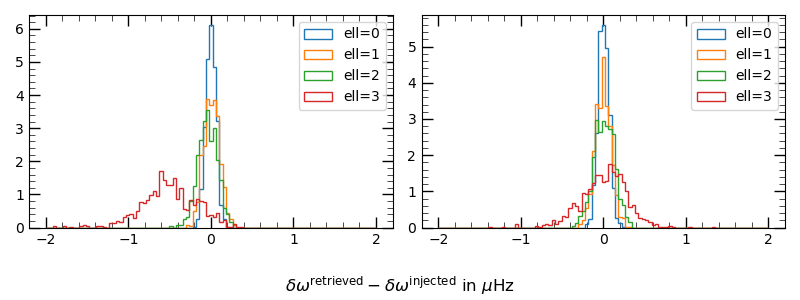

In [57]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
axs[0].hist((collect0fitval + shiftval)*dfreq, histtype=u'step', label='ell=0', bins=np.linspace(-2, 2, 100), density=True)
axs[0].hist((collect1fitval + shiftval)*dfreq, histtype=u'step', label='ell=1', bins=np.linspace(-2, 2, 100), density=True)
axs[0].hist((collect2fitval + shiftval)*dfreq, histtype=u'step', label='ell=2', bins=np.linspace(-2, 2, 100), density=True)
axs[0].hist((collect3fitval + shiftval)*dfreq, histtype=u'step', label='ell=3', bins=np.linspace(-2, 2, 100), density=True)

axs[1].hist((collect0fitval_corr + shiftval)*dfreq, histtype=u'step', label='ell=0', bins=np.linspace(-2, 2, 100), density=True)
axs[1].hist((collect1fitval_corr + shiftval)*dfreq, histtype=u'step', label='ell=1', bins=np.linspace(-2, 2, 100), density=True)
axs[1].hist((collect2fitval_corr + shiftval)*dfreq, histtype=u'step', label='ell=2', bins=np.linspace(-2, 2, 100), density=True)
axs[1].hist((collect3fitval_corr + shiftval)*dfreq, histtype=u'step', label='ell=3', bins=np.linspace(-2, 2, 100), density=True)
fig.supxlabel('$\\delta\\omega^\\mathrm{retrieved} - \\delta\\omega^\\mathrm{injected}$ in $\\mu$Hz', fontsize=12)
for _axs in axs: _axs.legend()
fig.tight_layout()

In [58]:
def gaussian_profile(x, *p):
    """Creates a gaussian with the defined parameters. Useful for 
    passing the function to scipy.optimize.curve_fit

    Parameters
    ----------
    :x: domain on which gaussian is defined
    :type: np.ndarray(ndim=1, dtype=float)

    :p: parameters corresponding to the gaussian
    :type: list(len=4)
        p[0] = Amplitude of gaussian
        p[1] = centroid location
        p[2] = sigma
        p[3] = dc shift

    Returns
    -------
    gaussian profile on x
    """
    mu, sigma, = p
    return np.exp(-(x-mu)**2/(2.*sigma**2))/np.sqrt(2*np.pi*sigma*sigma)

In [52]:
from statistics import NormalDist

In [ ]:
!module load texlive

In [ ]:
from matplotlib import rc
rc('font', **{'family':'serif', 'serif':['Helvetica']})
rc('text', usetex=True)

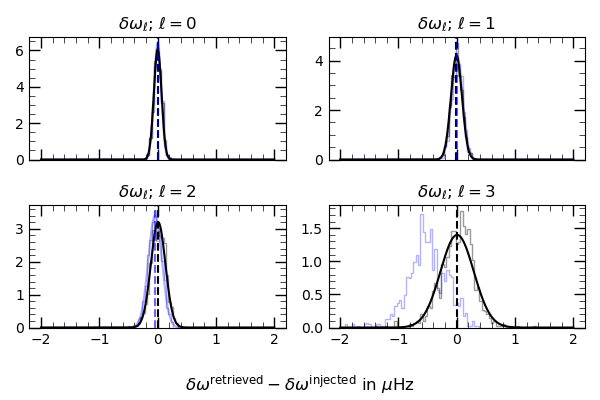

In [59]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(6, 4), sharex=True)

norm0 = NormalDist.from_samples((collect0fitval+shiftval)*dfreq)
norm1 = NormalDist.from_samples((collect1fitval+shiftval)*dfreq)
norm2 = NormalDist.from_samples((collect2fitval+shiftval)*dfreq)
norm3 = NormalDist.from_samples((collect3fitval+shiftval)*dfreq)
norm0c = NormalDist.from_samples((collect0fitval_corr+shiftval)*dfreq)
norm1c = NormalDist.from_samples((collect1fitval_corr+shiftval)*dfreq)
norm2c = NormalDist.from_samples((collect2fitval_corr+shiftval)*dfreq)
norm3c = NormalDist.from_samples((collect3fitval_corr+shiftval)*dfreq)

mu0, sig0 = norm0.mean, norm0.stdev
mu1, sig1 = norm1.mean, norm1.stdev
mu2, sig2 = norm2.mean, norm2.stdev
mu3, sig3 = norm3.mean, norm3.stdev
mu0c, sig0c = norm0c.mean, norm0c.stdev
mu1c, sig1c = norm1c.mean, norm1c.stdev
mu2c, sig2c = norm2c.mean, norm2c.stdev
mu3c, sig3c = norm3c.mean, norm3c.stdev

fontsize = 10
xarr = np.linspace(-2, 2, 1000)
axs = axs.flatten()
axs[0].hist((collect0fitval + shiftval)*dfreq, histtype=u'step', label='ell=0', bins=np.linspace(-2, 2, 100), density=True, color='b', alpha=0.3)
axs[1].hist((collect1fitval + shiftval)*dfreq, histtype=u'step', label='ell=1', bins=np.linspace(-2, 2, 100), density=True, color='b', alpha=0.3)
axs[2].hist((collect2fitval + shiftval)*dfreq, histtype=u'step', label='ell=2', bins=np.linspace(-2, 2, 100), density=True, color='b', alpha=0.3)
axs[3].hist((collect3fitval + shiftval)*dfreq, histtype=u'step', label='ell=3', bins=np.linspace(-2, 2, 100), density=True, color='b', alpha=0.3)
axs[0].plot(xarr, gaussian_profile(xarr, *(mu0, sig0)), 'b', alpha=0.3)
axs[1].plot(xarr, gaussian_profile(xarr, *(mu1, sig1)), 'b', alpha=0.3)
axs[2].plot(xarr, gaussian_profile(xarr, *(mu2, sig2)), 'b', alpha=0.3)
axs[3].plot(xarr, gaussian_profile(xarr, *(mu3, sig3)), 'b', alpha=0.3)
for idx, _axs in enumerate(axs): 
    _axs.set_title('$\\delta\\omega_\\ell$; ' + f'$\\ell=${idx}')
    _axs.tick_params(axis='both', labelsize=fontsize)

axs[0].hist((collect0fitval_corr + shiftval)*dfreq, histtype=u'step', label='ell=0', bins=np.linspace(-2, 2, 100), density=True, color='k', alpha=0.4)
axs[1].hist((collect1fitval_corr + shiftval)*dfreq, histtype=u'step', label='ell=1', bins=np.linspace(-2, 2, 100), density=True, color='k', alpha=0.4)
axs[2].hist((collect2fitval_corr + shiftval)*dfreq, histtype=u'step', label='ell=2', bins=np.linspace(-2, 2, 100), density=True, color='k', alpha=0.4)
axs[3].hist((collect3fitval_corr + shiftval)*dfreq, histtype=u'step', label='ell=3', bins=np.linspace(-2, 2, 100), density=True, color='k', alpha=0.4)

axs[0].plot(xarr, gaussian_profile(xarr, *(mu0c, sig0c)), 'k')
axs[1].plot(xarr, gaussian_profile(xarr, *(mu1c, sig1c)), 'k')
axs[2].plot(xarr, gaussian_profile(xarr, *(mu2c, sig2c)), 'k')
axs[3].plot(xarr, gaussian_profile(xarr, *(mu3c, sig3c)), 'k')

axs[0].axvline(x=mu0c, color='k', linestyle='dashed')
axs[1].axvline(x=mu1c, color='k', linestyle='dashed')
axs[2].axvline(x=mu2c, color='k', linestyle='dashed')
axs[3].axvline(x=mu3c, color='k', linestyle='dashed')

axs[0].axvline(x=mu0, color='b', linestyle='dashed', alpha=0.6)
axs[1].axvline(x=mu1, color='b', linestyle='dashed', alpha=0.6)
axs[2].axvline(x=mu2, color='b', linestyle='dashed', alpha=0.6)
axs[3].axvline(x=mu3, color='b', linestyle='dashed', alpha=0.6)

fig.supxlabel('$\\delta\\omega^\\mathrm{retrieved} - \\delta\\omega^\\mathrm{injected}$ in $\\mu$Hz', fontsize=12)
fig.tight_layout()
fig.savefig('/scratch/seismo/kashyap/cloud/Yandex.Disk/papers-posters-docs/2025-seismo-xl/apdx-twofilters-montecarlo.pdf')

In [65]:
collect3fitval_corr.std()*dfreq

0.2850747243526008

In [66]:
print(f"sig0 = {sig0:.3f}")
print(f"sig1 = {sig1:.3f}")
print(f"sig2 = {sig2:.3f}")
print(f"sig3 = {sig3:.3f}")

sig0 = 0.062
sig1 = 0.096
sig2 = 0.117
sig3 = nan


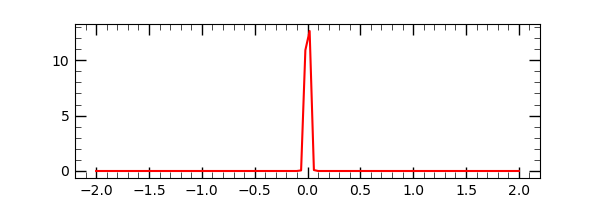

In [198]:
plt.figure(figsize=(6, 2))
_xarr = np.linspace(-2.0, 2.0, 100)
plt.plot(_xarr, gaussian_profile(_xarr, *(mu0c, sig0c/5)), 'r')

## Build leakage matrix

In [95]:
def compute_leakmat(type='corr'):
    collect0fitval_corr = []
    collect1fitval_corr = []
    collect2fitval_corr = []
    collect3fitval_corr = []
    num_realizations = 1000
    leak_mat = np.zeros((4, 4, num_realizations))
    for idx in tqdm(range(1000), desc='performing Montecarlo'):
        _p0s = noisify(pmod0s)
        _p1s = noisify(pmod1s)
        _p2s = noisify(pmod2s)
        _p3s = noisify(pmod3s)
        if type=='corr':
            __a0, __a00, cbg0 = get_freqlags_corrected(_p0s, pfilt_list)
            __a1, __a10, cbg1 = get_freqlags_corrected(_p1s, pfilt_list)
            __a2, __a20, cbg2 = get_freqlags_corrected(_p2s, pfilt_list)
            __a3, __a30, cbg3 = get_freqlags_corrected(_p3s, pfilt_list)
        else:
            __a0, __a00 = get_freqlags(_p0s, pfilt_list)
            __a1, __a10 = get_freqlags(_p1s, pfilt_list)
            __a2, __a20 = get_freqlags(_p2s, pfilt_list)
            __a3, __a30 = get_freqlags(_p3s, pfilt_list)
        collect0fitval_corr.append(__a00[1][0])
        collect1fitval_corr.append(__a10[1][1])
        collect2fitval_corr.append(__a20[1][2])
        collect3fitval_corr.append(__a30[1][3])
        for jdx in range(4): leak_mat[0, jdx, idx] = __a00[1][jdx]
        for jdx in range(4): leak_mat[1, jdx, idx] = __a10[1][jdx]
        for jdx in range(4): leak_mat[2, jdx, idx] = __a20[1][jdx]
        for jdx in range(4): leak_mat[3, jdx, idx] = __a30[1][jdx]
    
    collect0fitval_corr = np.array(collect0fitval_corr)
    collect1fitval_corr = np.array(collect1fitval_corr)
    collect2fitval_corr = np.array(collect2fitval_corr)
    collect3fitval_corr = np.array(collect3fitval_corr)
    return leak_mat, collect0fitval_corr, collect1fitval_corr, collect2fitval_corr, collect3fitval_corr

leak1mat, c0f, c1f, c2f, c3f = compute_leakmat(type='uncorr')
leak2mat, c0f_corr, c1f_corr, c2f_corr, c3f_corr = compute_leakmat(type='corr')

leakmat1mean = leak1mat.mean(axis=-1)*dfreq
leakmat2mean = leak2mat.mean(axis=-1)*dfreq
leakmat1norm = leakmat1mean/abs(shiftval)/dfreq
leakmat2norm = leakmat2mean/abs(shiftval)/dfreq

performing Montecarlo:   0%|          | 3/1000 [00:00<01:33, 10.68it/s]/tmp/ipykernel_45619/3255571043.py:19: OptimizeWarning: Covariance of the parameters could not be estimated
  coeff, var_matrix = curve_fit(gaussian, lags, corr, p0=p0)
performing Montecarlo:   0%|          | 3/1000 [00:00<02:37,  6.34it/s]/tmp/ipykernel_45619/2445068108.py:26: OptimizeWarning: Covariance of the parameters could not be estimated
  coeff, var_matrix = curve_fit(gaussian, lags, corr, p0=p0)
performing Montecarlo: 100%|██████████| 1000/1000 [02:36<00:00,  6.40it/s]


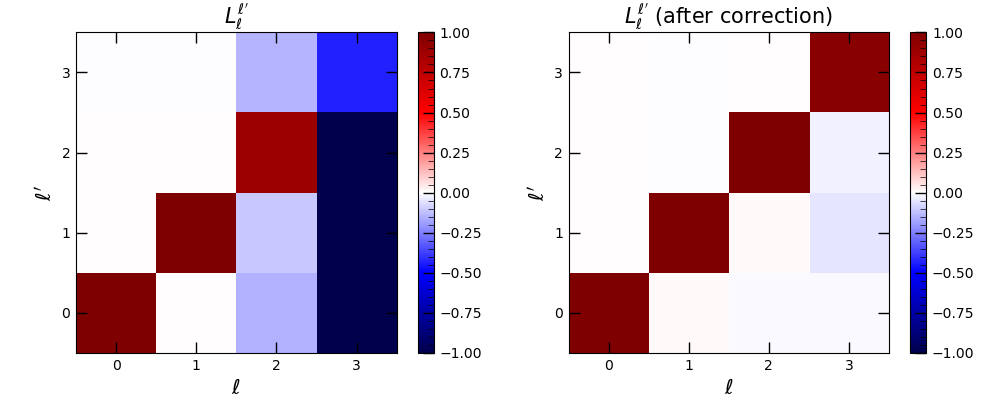

In [102]:
plt.close('all')
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
im0 = axs[0].imshow(leakmat1norm, extent=[-0.5, 3.5, -0.5, 3.5], origin='lower', vmax=1, vmin=-1, cmap='seismic')
im1 = axs[1].imshow(leakmat2norm, extent=[-0.5, 3.5, -0.5, 3.5], origin='lower', vmax=1, vmin=-1, cmap='seismic')
plt.colorbar(im0, ax=axs[0])
plt.colorbar(im1, ax=axs[1])
for _axs in axs:
    _axs.set_xticks(np.arange(4))
    _axs.set_yticks(np.arange(4))
    _axs.set_xlabel('$\\ell$', fontsize=15)
    _axs.set_ylabel("$\\ell'$", fontsize=15)
    _axs.set_xticks(np.arange(4))
    _axs.set_yticks(np.arange(4))
    _axs.minorticks_off()

axs[0].set_title("$L_\\ell^{\\ell'}$", fontsize=15)
axs[1].set_title("$L_\\ell^{\\ell'}$ (after correction)", fontsize=15)
fig.tight_layout()
fig.savefig("/scratch/seismo/kashyap/cloud/Yandex.Disk/papers-posters-docs/2025-seismo-xl/leakmat.pdf")

In [113]:
abs(leakmat2norm - np.diag(np.diag(leakmat2norm))).max()

0.04695753251440475

In [100]:
def compute_covmat(samples):
    cov_mat = np.zeros((4, 4))
    for idx in range(4):
        cvali = samples[idx]*dfreq
        cimean = cvali.mean()
        for jdx in range(4):
            cvalj = samples[jdx]*dfreq
            cjmean = cvalj.mean()
            cov_mat[idx, jdx] = np.mean((cvali - cimean)*(cvalj - cjmean))
    return cov_mat

cval1list = np.vstack((c0f, c1f, c2f, c3f))
cval2list = np.vstack((c0f_corr, c1f_corr, c2f_corr, c3f_corr))
cov1mat = compute_covmat(cval1list)
cov2mat = compute_covmat(cval2list)
        

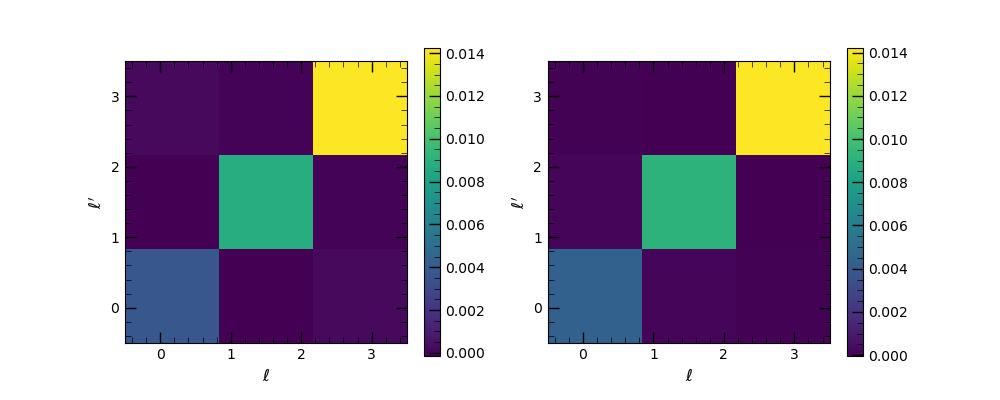

In [105]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
im0 = axs[0].imshow(cov1mat[:3, :3], extent=[-0.5, 3.5, -0.5, 3.5], origin='lower')
im1 = axs[1].imshow(cov2mat[:3, :3], extent=[-0.5, 3.5, -0.5, 3.5], origin='lower')
plt.colorbar(im0, ax=axs[0])
plt.colorbar(im1, ax=axs[1])
for _axs in axs:
    _axs.set_xticks(np.arange(4))
    _axs.set_yticks(np.arange(4))
    _axs.set_xlabel('$\\ell$', fontsize=12)
    _axs.set_ylabel("$\\ell'$", fontsize=12)

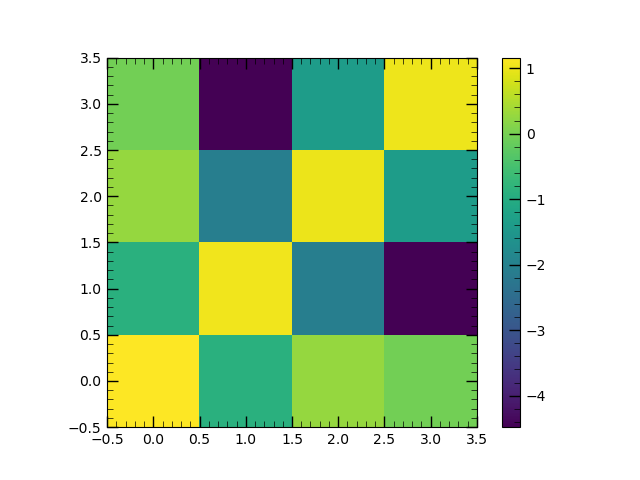

In [109]:
plt.figure()
im = plt.imshow(cov2mat/cov1mat, origin='lower')
plt.colorbar(im)

In [ ]:
plt.figure()
plt.plot(np.sqrt(np.diag(cov_mat)), '+')
plt.xticks(np.arange(4))

## How does different frequency splittings result in the computation of averaged spectra
- Currently the injection retreival tests only include a constant frequency shift applied to all modes
- What would happen if we introduce $\delta\nu(n, \ell)$? -- **how is $\bar{\delta\nu}_\ell$ related to the individual splittings?**
- Which splittings are the $\bar{\delta\nu}_\ell$ dominantly sensitive to? - $a_0, a_1, a_2, a_3$ -- derive sensitivity kernels for each of these
  

- Can individual splittings be detected using this technique? 
- The problem here is that there could be multiple maxima in the cross-corelation function
- Can mode-mass scaled cross correlation be performed? -- reasonably easy to implement

In [ ]:
def cross_correlation_modemass_scaled(arr1, arr2, ell, enns):
    def compute_modemass(enn, ell):
        modemass = 1.0
        return modemass


    def compute_shifted_arr2(arr2, ell, enns, shiftval):
        return np.roll(arr2, shiftval)
        
    """Computes the cross-correlation for lags in the range (-maxlag, maxlag+1)

    Parameters
    ----------
    :arr1: the raw power spectrum
    :type: np.ndarray(ndim=1, dtype=float)

    :arr2: the filter power spectrum model
    :type: np.ndarray(ndim=1, dtype=float)

    :maxlag: the maximum lag index
    :type: int
    :default: 20

    Returns
    -------
    lags, cc

    :lags: array containing list of lags
    :type: np.ndarray(ndim=1, dtype=int)
    :note: lags = np.arange(-maxlag, maxlag+1)

    :cc: cross-correlation array
    :type: np.ndarray(ndim=1, dtype=float)
    """
    maxlag = abs(int(maxlag))
    assert maxlag > 0, "maxlag should be at least 1"
    if maxlag%2>0: maxlag += 1
    cc = np.zeros(2*maxlag+1)
    lags = np.arange(-maxlag, maxlag+1)
    for idx in range(len(cc)):
        cc[idx] = np.sum(arr1*compute_shifted_arr2(arr2, ell, enns, idx-maxlag))
    return lags, cc

    